In [1]:
from pathlib import Path
import sys

# More reliable: get the project root from the notebook's location
ROOT_PATH = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
# Or even better for notebooks:
ROOT_PATH = Path().resolve().parent  # Goes up from notebooks/ folder

sys.path.append(str(ROOT_PATH))

from src.data.dataset import OrionAEFrameDataset, CWTScalogramDataset

In [2]:
import yaml

with open('/home/serene/orion-ae-study/configs/dataset/cwt_scalogram_A_SHM.yaml', 'r') as f:
    cfg_data = yaml.safe_load(f)['dataset']
    

cwt = CWTScalogramDataset(
    data_path=r'/home/serene/orion-ae-study/data/processed/example_1_features_20260109_001526',
    config=cfg_data,
    type='all'
)

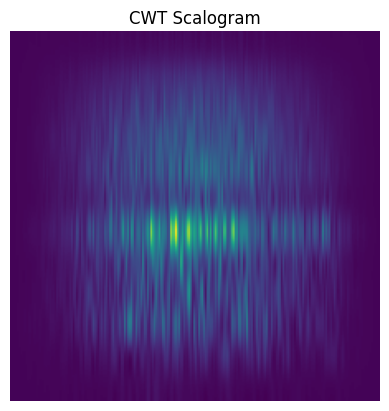

In [3]:
import matplotlib.pyplot as plt
import numpy as np

cwt_image = cwt[0]['final']

# Convert from CHW (3, H, W) to HWC (H, W, 3) format for matplotlib
if isinstance(cwt_image, np.ndarray) and cwt_image.ndim == 3:
    # Transpose from (C, H, W) to (H, W, C)
    cwt_image = np.transpose(cwt_image, (1, 2, 0))

# Normalize/clip values for display (assuming values might be outside [0, 1] or [0, 255])
if cwt_image.dtype != np.uint8:
    # If values are in [0, 1] range, scale to [0, 255]
    if cwt_image.max() <= 1.0:
        cwt_image = (cwt_image * 255).astype(np.uint8)
    else:
        # Clip to valid range and convert to uint8
        cwt_image = np.clip(cwt_image, 0, 255).astype(np.uint8)

plt.imshow(cwt_image)
plt.title("CWT Scalogram")
plt.axis('off')
plt.show()

In [56]:
import numpy as np
from collections import defaultdict

def compute_average_scalograms(dataset, target_serie, num_labels=7):
    """
    Compute average CWT scalograms per label for a specific series.
    
    Args:
        dataset: CWTScalogramDataset or similar iterable
        target_serie: Series to filter (e.g., 'B', 'C', 'D', 'E', 'F')
        num_labels: Number of label classes (default: 7)
    
    Returns:
        List of average scalograms, one per label (None if no samples)
    """
    # Group by label in single pass
    label_images = defaultdict(list)
    for data in dataset:
        if data['serie'] == target_serie:
            label_images[data['label']].append(data['final'])
    
    # Vectorized average per label
    avg_cwt = [None] * num_labels
    for label, images in label_images.items():
        if images:
            avg_cwt[label] = np.mean(np.stack(images), axis=0)
    
    return avg_cwt

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_scalograms(avg_cwt, title="Average CWT Scalograms by Label", 
                            figsize=(28, 6), fontsize=14):
    """
    Plot average CWT scalograms for each label.
    
    Args:
        avg_cwt: List of average scalograms per label (from compute_average_scalograms)
        title: Plot title
        figsize: Figure size tuple (width, height)
        fontsize: Font size for labels
    """
    num_labels = len(avg_cwt)
    fig, axes = plt.subplots(1, num_labels, figsize=figsize)
    
    for i, avg_img in enumerate(avg_cwt):
        ax = axes[i]
        if avg_img is not None:
            # Convert from (3, 224, 224) to (224, 224, 3)
            img_disp = np.transpose(avg_img, (1, 2, 0))
            # Normalize/clamp for display
            if img_disp.dtype != np.uint8:
                if img_disp.max() <= 1.0:
                    img_disp = (img_disp * 255).astype(np.uint8)
                else:
                    img_disp = np.clip(img_disp, 0, 255).astype(np.uint8)
            ax.imshow(img_disp)
            ax.set_title(f"Label {i}", fontsize=fontsize)
        else:
            ax.set_title(f"Label {i}\n(No samples)", fontsize=fontsize)
        ax.axis('off')
    
    plt.suptitle(title, fontsize=fontsize + 2)
    plt.tight_layout()
    plt.show()

In [58]:
avg_B = compute_average_scalograms(cwt, target_serie='B')
avg_C = compute_average_scalograms(cwt, target_serie='C')
avg_D = compute_average_scalograms(cwt, target_serie='D')
avg_E = compute_average_scalograms(cwt, target_serie='E')
avg_F = compute_average_scalograms(cwt, target_serie='F')

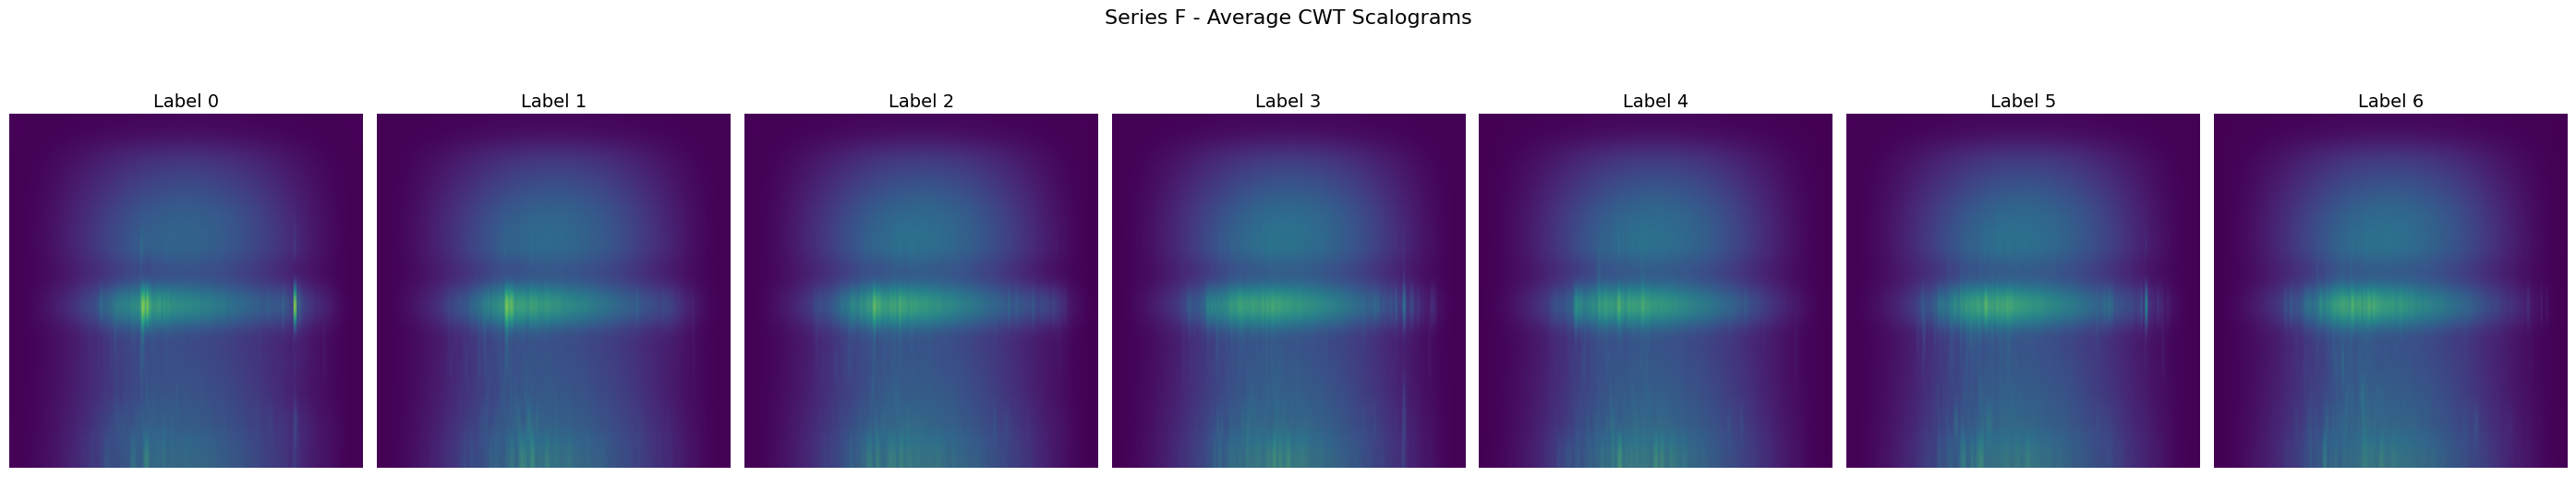

In [59]:
plot_average_scalograms(avg_F, title="Series F - Average CWT Scalograms")

In [60]:
def plot_series_comparison(dataset, series_list=['B', 'C', 'D', 'E'], label=0):
    """Compare same label across different series."""
    fig, axes = plt.subplots(1, len(series_list), figsize=(20, 5))
    
    for i, serie in enumerate(series_list):
        avg = compute_average_scalograms(dataset, target_serie=serie)
        if avg[label] is not None:
            img = np.transpose(avg[label], (1, 2, 0))
            img = np.clip(img, 0, 255).astype(np.uint8)
            axes[i].imshow(img)
        axes[i].set_title(f"Series {serie}")
        axes[i].axis('off')
    
    plt.suptitle(f"Label {label} Across Series")
    plt.show()

# Check if patterns are consistent across series for same load
# plot_series_comparison(cwt, label=0)  # Low load
# plot_series_comparison(cwt, label=6)  # High load

## Scalogram Analysis Functions

The following functions help analyze the average scalograms:
- **Difference Maps**: Visualize which frequency-time regions distinguish between classes
- **Frequency Band Energy**: Analyze energy distribution across frequency bands per label
- **Variance Analysis**: Identify which classes have high/low variability
- **Summary Statistics**: Print statistics for quick comparison


In [61]:
def plot_difference_map(avg_cwt, label1, label2, title_prefix=""):
    """
    Show difference between two load levels.
    Highlights which frequency-time regions distinguish the classes.
    
    Args:
        avg_cwt: List of average scalograms per label
        label1: First label index
        label2: Second label index
        title_prefix: Optional prefix for title
    """
    if avg_cwt[label1] is None or avg_cwt[label2] is None:
        print(f"Missing data for label {label1} or {label2}")
        return
    
    diff = np.abs(avg_cwt[label1] - avg_cwt[label2])
    diff_img = np.transpose(diff, (1, 2, 0))
    
    # Normalize for display
    diff_norm = (diff_img - diff_img.min()) / (diff_img.max() - diff_img.min() + 1e-8)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(diff_norm)
    plt.colorbar(label='Absolute Difference (normalized)')
    plt.title(f"{title_prefix}Difference: Label {label1} vs Label {label2}")
    plt.xlabel("Time")
    plt.ylabel("Frequency (low → high)")
    plt.show()


In [62]:
def analyze_frequency_bands(avg_cwt, title="Frequency Band Energy by Load Level"):
    """
    Analyze energy distribution across frequency bands per label.
    Shows how energy shifts across frequencies with different loads.
    
    Args:
        avg_cwt: List of average scalograms per label
        title: Plot title
    """
    energy_per_label = []
    
    for label, img in enumerate(avg_cwt):
        if img is not None:
            # Sum energy across time (axis=2) and channels (axis=0)
            # img shape: (3, 224, 224) = (channels, freq, time)
            freq_energy = np.mean(img, axis=(0, 2))  # Average over channels and time
            energy_per_label.append(freq_energy)
        else:
            energy_per_label.append(None)
    
    # Plot
    plt.figure(figsize=(12, 6))
    for label, energy in enumerate(energy_per_label):
        if energy is not None:
            plt.plot(energy, label=f"Label {label}", linewidth=2)
    
    plt.xlabel("Frequency Band (row index, low freq → high freq)")
    plt.ylabel("Average Energy")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()


In [63]:
def compute_variance_scalograms(dataset, target_serie, num_labels=7):
    """
    Compute variance of scalograms per label.
    High variance = inconsistent patterns (harder to classify).
    
    Args:
        dataset: CWTScalogramDataset or similar iterable
        target_serie: Series to filter
        num_labels: Number of label classes
    
    Returns:
        List of variance scalograms, one per label (None if insufficient samples)
    """
    label_images = defaultdict(list)
    for data in dataset:
        if data['serie'] == target_serie:
            label_images[data['label']].append(data['final'])
    
    var_cwt = [None] * num_labels
    for label, images in label_images.items():
        if len(images) > 1:  # Need at least 2 samples for variance
            var_cwt[label] = np.var(np.stack(images), axis=0)
    
    return var_cwt


In [64]:
def print_scalogram_stats(dataset, series_list=['B', 'C', 'D', 'E', 'F']):
    """
    Print summary statistics for scalograms across series and labels.
    Useful for quick comparison of intensity distributions.
    
    Args:
        dataset: CWTScalogramDataset or similar iterable
        series_list: List of series to analyze
    """
    print(f"{'Series':<8} {'Label':<8} {'Mean':<12} {'Std':<12} {'Max':<12}")
    print("-" * 52)
    
    for serie in series_list:
        avg = compute_average_scalograms(dataset, target_serie=serie)
        for label, img in enumerate(avg):
            if img is not None:
                print(f"{serie:<8} {label:<8} {img.mean():<12.4f} {img.std():<12.4f} {img.max():<12.4f}")


## Usage Examples

### Difference Maps
Compare adjacent classes to see subtle differences, or compare extremes to see major pattern changes.


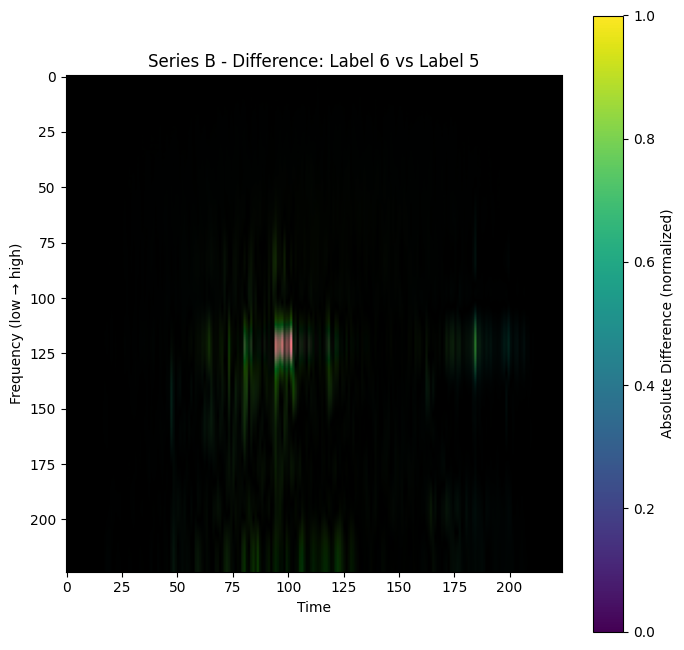

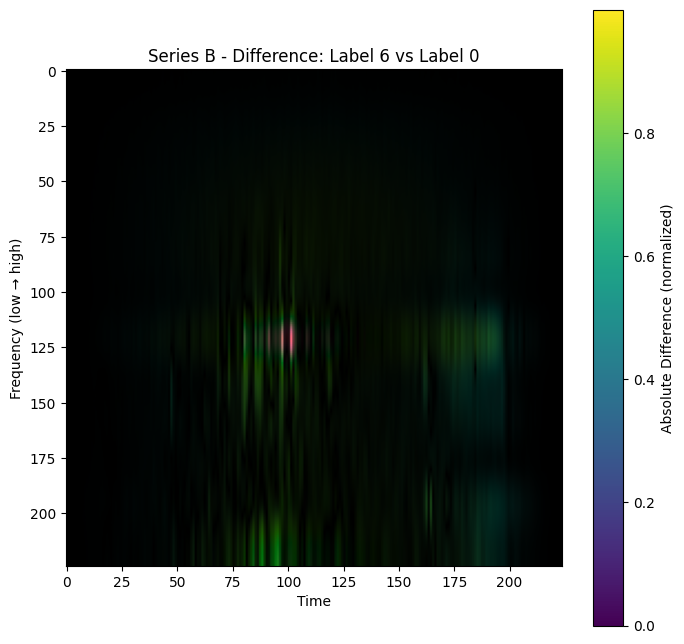

In [66]:
# Compare adjacent classes (subtle differences)
plot_difference_map(avg_B, 6, 5, title_prefix="Series B - ")

# Compare extremes (major differences)
plot_difference_map(avg_B, 6, 0, title_prefix="Series B - ")


### Frequency Band Energy Analysis
Shows how energy distribution across frequency bands changes with different load levels.


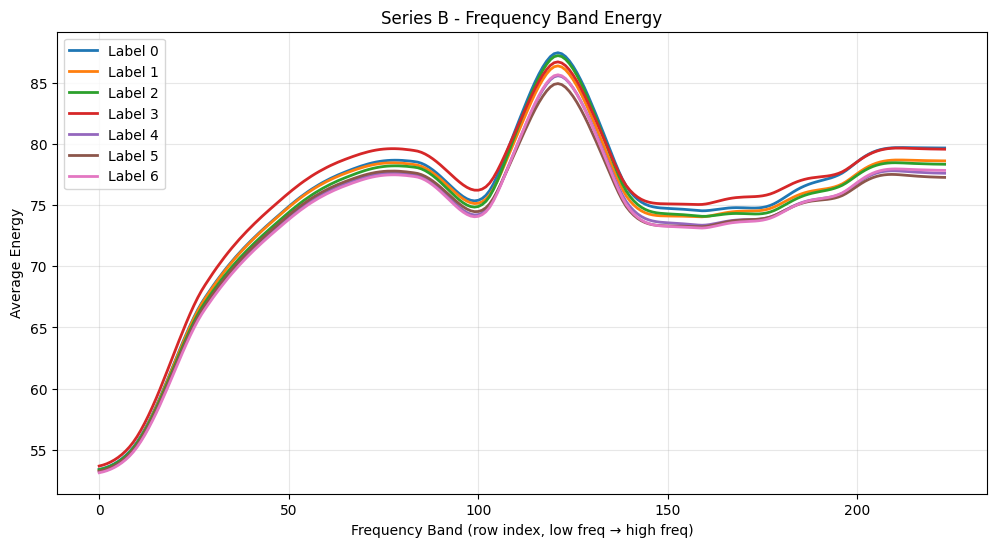

In [67]:
analyze_frequency_bands(avg_B, title="Series B - Frequency Band Energy")


### Variance Analysis
High variance regions indicate inconsistent patterns (harder to classify). Bright regions show high variability.


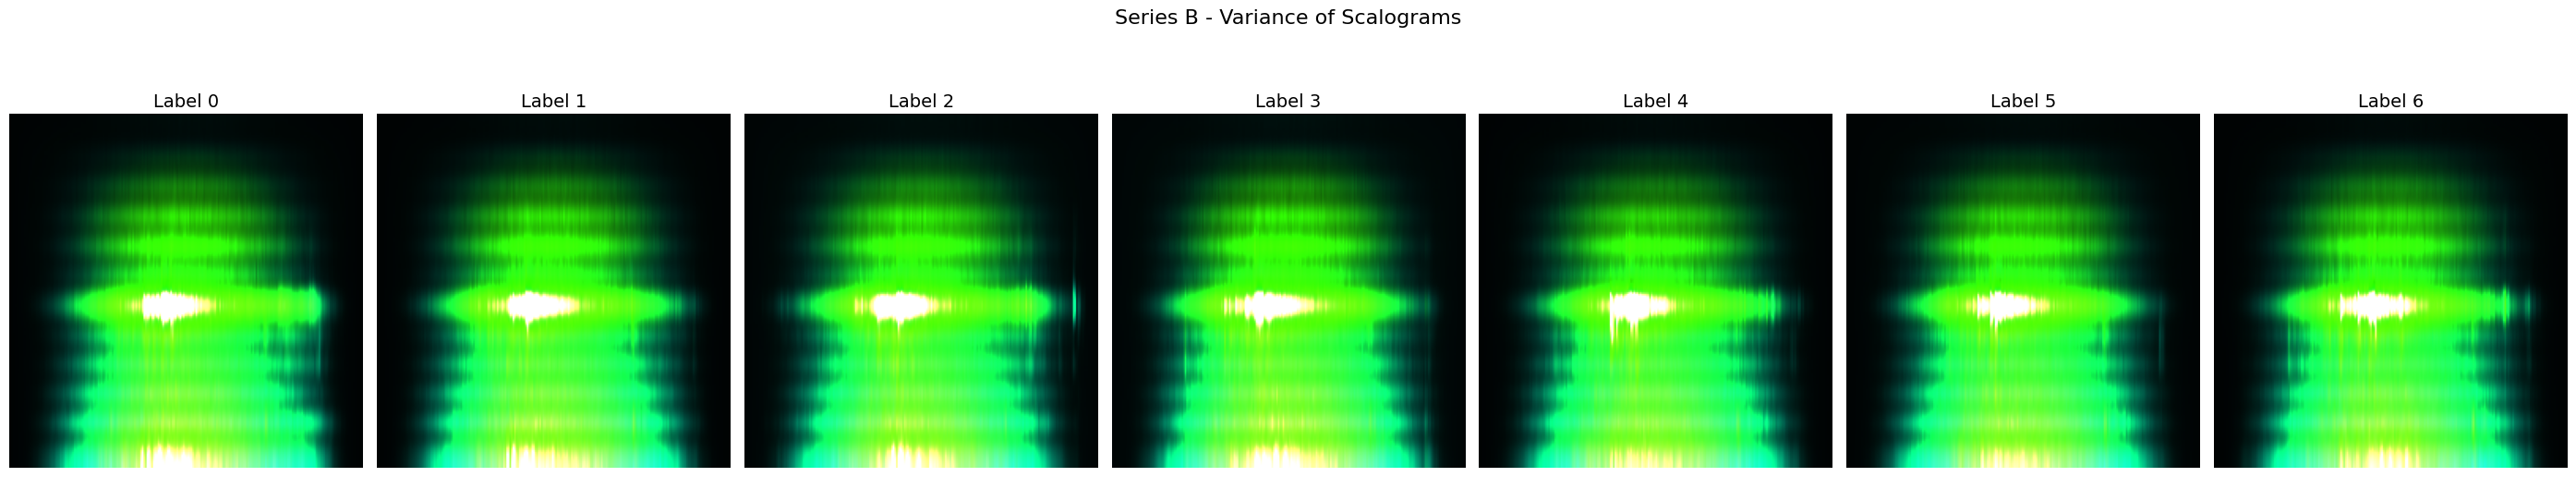

In [68]:
var_B = compute_variance_scalograms(cwt, 'B')
plot_average_scalograms(var_B, title="Series B - Variance of Scalograms")


### Summary Statistics
Quick overview of mean, std, and max values across all series and labels.


In [ ]:
print_scalogram_stats(cwt, series_list=['B', 'C', 'D', 'E', 'F'])


Series   Label    Mean         Std          Max         
----------------------------------------------------
